In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/bf/.fastai/data/imdb_sample/texts.csv')]

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [4]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [5]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

# Tokenization

In [6]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


In [7]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [8]:
data.train_ds[0][0].data[:10]

array([   2,   19,  267,   20,   32,   18,  104,    0, 1217,   18])

In [9]:
import gc
del data
gc.collect()

79

# Language model

In [10]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
           .split_from_df(col=2)
           .label_from_df(cols=0)
           .databunch())

In [7]:
bs=48

In [12]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/bf/.fastai/data/imdb/unsup'),
 PosixPath('/home/bf/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/bf/.fastai/data/imdb/README'),
 PosixPath('/home/bf/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/bf/.fastai/data/imdb/train'),
 PosixPath('/home/bf/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/bf/.fastai/data/imdb/test'),
 PosixPath('/home/bf/.fastai/data/imdb/models'),
 PosixPath('/home/bf/.fastai/data/imdb/data_lm.pkl')]

In [13]:
(path/'train').ls()

[PosixPath('/home/bf/.fastai/data/imdb/train/neg'),
 PosixPath('/home/bf/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/bf/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/bf/.fastai/data/imdb/train/pos')]

In [14]:
data_lm = (TextList.from_folder(path)
          .filter_by_folder(include=['train', 'test', 'unsup'])
          .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs))

In [15]:
data_lm.save('data_lm.pkl')

In [16]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [17]:
data_lm.show_batch()

idx,text
0,"show , and a xxmaj mighty xxmaj wind , xxmaj for xxmaj your xxmaj consideration is largely improvised , and reunites the same winning cast . xxmaj gone , however , are several of the conventions of xxmaj guest 's previous films . xxmaj for xxmaj your xxmaj consideration avoids the need to give every last character an extended ' interview ' segment and instead weaves minor characters naturally into"
1,"'s feelings , or the people they hurt . xxmaj if anything those characters in xxmaj crash come across as being selfish , as well as perverse . \n \n xxmaj another problem is the actual point of this film- what message is this trying to evoke to its audience ? xxmaj what can the audience themselves take away from this viewing experience ? xxmaj and is there a"
2,"kingsley ( the police ) looks angry at times is because he´s starting to realize the movie will suck . xxbos i saw this movie a long time ago and as i remember it , it was pretty depressing . xxmaj it was about this family during the great depression who struggle with farm life . i think that there is a grandmother in this movie who gets left behind"
3,awestruck by the sacrifice he made . xxmaj the scene in which he met and spoke with his son was so touching ! ! xxmaj this is an awesome must - see for xxmaj orson xxmaj welles fans . xxmaj also the casting of a young xxmaj richard xxmaj long and a very young xxmaj natalie xxmaj wood was a stroke of genius ! ! xxbos a game rarely comes
4,"and a lackluster musical score . xxmaj there are many , many xxmaj black - xxmaj american films from the 70s that are so much better and more interesting than this dull mess . xxbos xxmaj let me begin this review by saying that xxmaj universal 's xxup dvd release of this film is beneath contempt . xxmaj it 's exactly the same as the xxmaj polygram xxup vhs release"


In [18]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).to_fp16()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


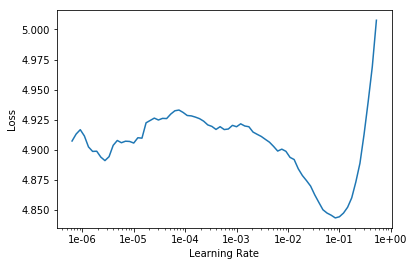

In [20]:
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.191515,4.058967,0.293333,51:19


In [22]:
learn.save('fit_head')

In [23]:
learn.load('fit_head');

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.951197,3.882528,0.310842,58:14
1,3.895305,3.811881,0.320177,58:12
2,3.817405,3.767791,0.325785,58:14
3,3.763133,3.727886,0.330675,58:13
4,3.681572,3.697211,0.333925,58:13
5,3.629203,3.673589,0.336574,58:11
6,3.564322,3.654320,0.338973,58:12
7,3.543004,3.642004,0.340414,58:13
8,3.485329,3.636350,0.341064,58:12
9,3.472397,3.635879,0.341092,58:14


In [26]:
learn.save('fine_tuned')

In [27]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj there is something both enchanting and disorienting about watching a xxmaj christopher xxmaj guest film that features conventional camera angles and a narrative structure . xxmaj it is a brave , and ultimately , a rewarding choice for a director who has built his impeccable reputation on the strength of his mockumentaries . 
 
  xxmaj like its predecessors xxmaj waiting for xxmaj guffman , xxmaj best in xxmaj show , and a xxmaj mighty xxmaj wind , xxmaj for xxmaj your xxmaj consideration is largely improvised , and reunites the same winning cast . xxmaj gone , however , are several of the conventions of xxmaj guest 's previous films . xxmaj for xxmaj your xxmaj consideration avoids the need to give every last character an extended ' interview ' segment and instead weaves minor characters naturally into the fabric of the story . xxmaj the narrative structure also prevents xxmaj guest from rel

In [28]:
TEXT = "I am Ben and I am "
N_WORDS = 40
N_SENTENCES = 2

In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I am Ben and I am  at a loss to explain why this movie was canceled , i really do n't understand why you should n't watch it . You have to take the time to be shoes and leave the room and watch this
I am Ben and I am  a Ben Affleck fan . He is the most talented actor in the world . He is an amazing actor and i remember giving him his own movie , SUCCESSFUL . He is a


In [30]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [2]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg', 'pos'])
            .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [3]:
data_clas = load_data(path, 'data_clas.pkl', bs=48)

In [4]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxup xxunk "" and "" xxup beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this",neg
"xxbos xxmaj okay , so i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games",neg
"xxbos xxup warning : xxup possible xxup spoilers ( but not really - keep reading ) . xxmaj ahhh , there are so many reasons to become utterly addicted to this spoof gem that i wo n't have room to list them all . xxmaj the opening credits set the playful scene with kitsch late 1950s cartoon stills ; an enchanting xxmaj xxunk ' xxmaj prez ' xxmaj xxunk mambo",pos
"xxbos xxmaj now that xxmaj xxunk ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both hosts of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",neg


In [3]:
data_clas = load_data(path, 'data_clas.pkl', bs=16)

In [4]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.load_encoder('fine_tuned_enc')

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


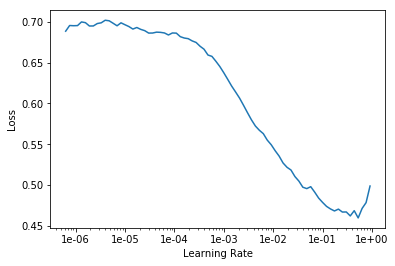

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.271174,0.192404,0.926040,06:27


In [38]:
learn.save('first')

In [41]:
learn.load('first')

/home/bf/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/basic_train.py:327: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj oh my , this was the worst reunion movie i have ever seen . ( xxmaj that is saying a lot . ) i am ashamed of watching . 
 
  xxmaj what happened in the script meetings ? " o xxrep 5 o h , i know ! xxmaj let 's have two stud muffins fall madly in love with the xxmaj most - xxmaj annoying - xxmaj character - xxmaj since - xxmaj cousin - xxmaj oliver . " " xxmaj yeah , that 'll be cool ! " 
 
  xxmaj even for sitcoms , this was the most implausible plot since xxmaj ron xxmaj xxunk starting spray painting bald men .,xxbos xxmaj there are so many puns to play on the title of the spectacularly bad xxmaj valentine that i do n't know where to begin . i will say this though ; here is a movie that makes me long for the complexity of the xxmaj valentine cards we used to give out in elementary school . xxmaj you know , the ones with xxmaj batman exclaiming " xxmaj you 're a super crime - fighting valentine !

In [42]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.248833,0.170585,0.935200,06:50


In [43]:
learn.save('second')

In [13]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj oh my , this was the worst reunion movie i have ever seen . ( xxmaj that is saying a lot . ) i am ashamed of watching . 
 
  xxmaj what happened in the script meetings ? " o xxrep 5 o h , i know ! xxmaj let 's have two stud muffins fall madly in love with the xxmaj most - xxmaj annoying - xxmaj character - xxmaj since - xxmaj cousin - xxmaj oliver . " " xxmaj yeah , that 'll be cool ! " 
 
  xxmaj even for sitcoms , this was the most implausible plot since xxmaj ron xxmaj xxunk starting spray painting bald men .,xxbos xxmaj there are so many puns to play on the title of the spectacularly bad xxmaj valentine that i do n't know where to begin . i will say this though ; here is a movie that makes me long for the complexity of the xxmaj valentine cards we used to give out in elementary school . xxmaj you know , the ones with xxmaj batman exclaiming " xxmaj you 're a super crime - fighting valentine !

In [14]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.208184,0.153143,0.943200,09:01


In [15]:
learn.save('third')

In [5]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj oh my , this was the worst reunion movie i have ever seen . ( xxmaj that is saying a lot . ) i am ashamed of watching . 
 
  xxmaj what happened in the script meetings ? " o xxrep 5 o h , i know ! xxmaj let 's have two stud muffins fall madly in love with the xxmaj most - xxmaj annoying - xxmaj character - xxmaj since - xxmaj cousin - xxmaj oliver . " " xxmaj yeah , that 'll be cool ! " 
 
  xxmaj even for sitcoms , this was the most implausible plot since xxmaj ron xxmaj xxunk starting spray painting bald men .,xxbos xxmaj there are so many puns to play on the title of the spectacularly bad xxmaj valentine that i do n't know where to begin . i will say this though ; here is a movie that makes me long for the complexity of the xxmaj valentine cards we used to give out in elementary school . xxmaj you know , the ones with xxmaj batman exclaiming " xxmaj you 're a super crime - fighting valentine !

In [6]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.204342,0.149777,0.943680,25:48
1,0.200888,0.145046,0.945720,24:42


In [7]:
learn.save('final')

In [8]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0011, 0.9989]))

In [10]:
learn.predict("Ben Fung is a nice guy.")

(Category pos, tensor(1), tensor([0.1487, 0.8513]))

(Category neg, tensor(0), tensor([0.6825, 0.3175]))